The code below selects 16 128x128 tiles for each image and mask based on the maximum number of tissue pixels. The kernel also provides computed image stats. Please check my kernels to see how to use this data. 
![](https://i.ibb.co/RzSWP56/convert.png)

In [1]:
import os
import cv2
import skimage.io
from tqdm import tqdm, tqdm_notebook
import zipfile
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
#Image.MAX_IMAGE_PIXELS=2000000000

In [2]:
LOCAL_DIR = '/home/cancer_research/data/panda-kaggle/'
TRAIN = LOCAL_DIR + 'radboud_images/'
MASKS = LOCAL_DIR + 'radboud_masks/'

OUT_DIR = '/media/tjhart/M.2 Vol 2/'
OUT_IMAGE_TRAIN = OUT_DIR + 'image_train.zip'
OUT_IMAGE_VALIDATION = OUT_DIR + 'image_validation.zip'
OUT_MASK_TRAIN = OUT_DIR + 'mask_train.zip'
OUT_MASK_VALIDATION = OUT_DIR + 'mask_validation.zip'

SZ = 60


## Create Image Tiles

In [3]:
def tile(img):
    """
    This function creates tiles of the image and its corresponding mask. This function 
    returns a list with a dictionary for each tile.
    The tiles are returned in a dictionary. The image is given an index 
    which orders tiles from the tiles with the least white space to the tiles 
    with the most white space. It also gives the tile a location which corresponds 
    to the location of the tile in the image before it was tiled.
    
    parameters:
    -----------
    img: image to tile
    mask: corresponding mask
    
    returns:
    result (list of dicts): This is a list of dictionaries corresponding to each tile
        img: the tile
        mask: the corresponding mask tile
        idx (int): The tiles are ordered according to how much white space they have. Tiles 
        with less white space have a smaller index
        location ([int,int]): this is a list of two integers corresponding to the original 
        location of the tile in the image
    """

    #Get initial variables
    result = []
    shape = img.shape

    # Find the values to pad h and w with so the dimensions are multiples
    # of SZ
    pad0,pad1,pad2 = (SZ - shape[0]%SZ)%SZ, (SZ - shape[1]%SZ)%SZ, (SZ - shape[2]%SZ)%SZ

    # The images and masks with chosen constants
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[pad2//2,pad2-pad2//2]],
                constant_values=255)

    # Reshape images to a x SZ x b x SZ x 3 (a and b depend on the original size of image)
    img = img.reshape(img.shape[0]//SZ,SZ,img.shape[1]//SZ,SZ,img.shape[2]//SZ,)
    n_tiles_height = img.shape[0]
    n_tiles_width = img.shape[2]
    
    #swap order of dimensions
    img = img.transpose(0,2,1,3,4).reshape(-1,SZ,SZ,3)

    
    # reshape image and sum along last dimension
    #then order those values in ascending order and return
    #the index of the images that are not all white
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))
    sums = img.reshape(img.shape[0],-1).sum(-1)

    # Only keep images that are not all white
    idxs_to_keep = [i for i in range(len(sums)) if sums[i] < 200540160]
    sums_to_keep = [s for s in sums if s < 200540160].notebook 
    idxs_to_keep = [i for _,i in sorted(zip(sums_to_keep, idxs_to_keep))]
    img = img[idxs_to_keep]
    mask = mask[idxs_to_keep]
    
    # Get tile locations in original image
    locations = [[int(np.floor(i/n_tiles_width)),i%n_tiles_width] for i in idxs_to_keep]
    
    # Add dictionary to list 
    for i in range(len(img)):
        result.append({'img':img[i], 'mask':mask[i], 'idx':i, 'location':locations[i]})
        
    return result

In [4]:
# Set initial variables
x_tot,x2_tot = [],[]
names = [name[:-10] for name in os.listdir(MASKS)]

# Get list of images to train and list to validate
train = open('../data/train.txt','r').readlines()
train = [x.split('\n')[0] for x in train]
validation = open('../data/validation.txt','r').readlines()
validation = [x.split('\n')[0] for x in validation]


# Go through each image and create tiles
with zipfile.ZipFile(OUT_IMAGE_TRAIN, 'w') as img_train_out,\
 zipfile.ZipFile(OUT_MASK_TRAIN, 'w') as mask_train_out,\
 zipfile.ZipFile(OUT_MASK_VALIDATION, 'w') as mask_validate_out,\
 zipfile.ZipFile(OUT_IMAGE_VALIDATION, 'w') as img_validate_out:
    for name in tqdm(names):
        try:
            #load images
            img = skimage.io.MultiImage(os.path.join(TRAIN,name+'.tiff'))[-1]
            mask = skimage.io.MultiImage(os.path.join(MASKS,name+'_mask.tiff'))[-1]
        
            #Get tiles for images
            tiles = tile(img,mask)
            for t in tiles:
                img,mask,idx, location = t['img'],t['mask'],t['idx'],t['location']
                x_tot.append((img/255.0).reshape(-1,3).mean(0))
                x2_tot.append(((img/255.0)**2).reshape(-1,3).mean(0)) 
                
                #if read with PIL RGB turns into BGR
                #Convert images and masks to png images
                img = cv2.imencode('.png',cv2.cvtColor(img, cv2.COLOR_RGB2BGR))[1]
                mask = cv2.imencode('.png',mask[:,:,0])[1]

                if name in train:
                    img_train_out.writestr(f'{name}_{idx}_{location[0]}_{location[1]}.png', img)
                    mask_train_out.writestr(f'{name}_{idx}_{location[0]}_{location[1]}_mask.png', mask)
                elif name in validation:
                    img_validate_out.writestr(f'{name}_{idx}_{location[0]}_{location[1]}.png', img)
                    mask_validate_out.writestr(f'{name}_{idx}_{location[0]}_{location[1]}_mask.png', mask)
                else:
                    print(name, 'not in train or validation')
        except Exception as e:
            print(name)
            print(e)

  0%|          | 0/5058 [00:00<?, ?it/s]

## Reconstruct specific image after tiling

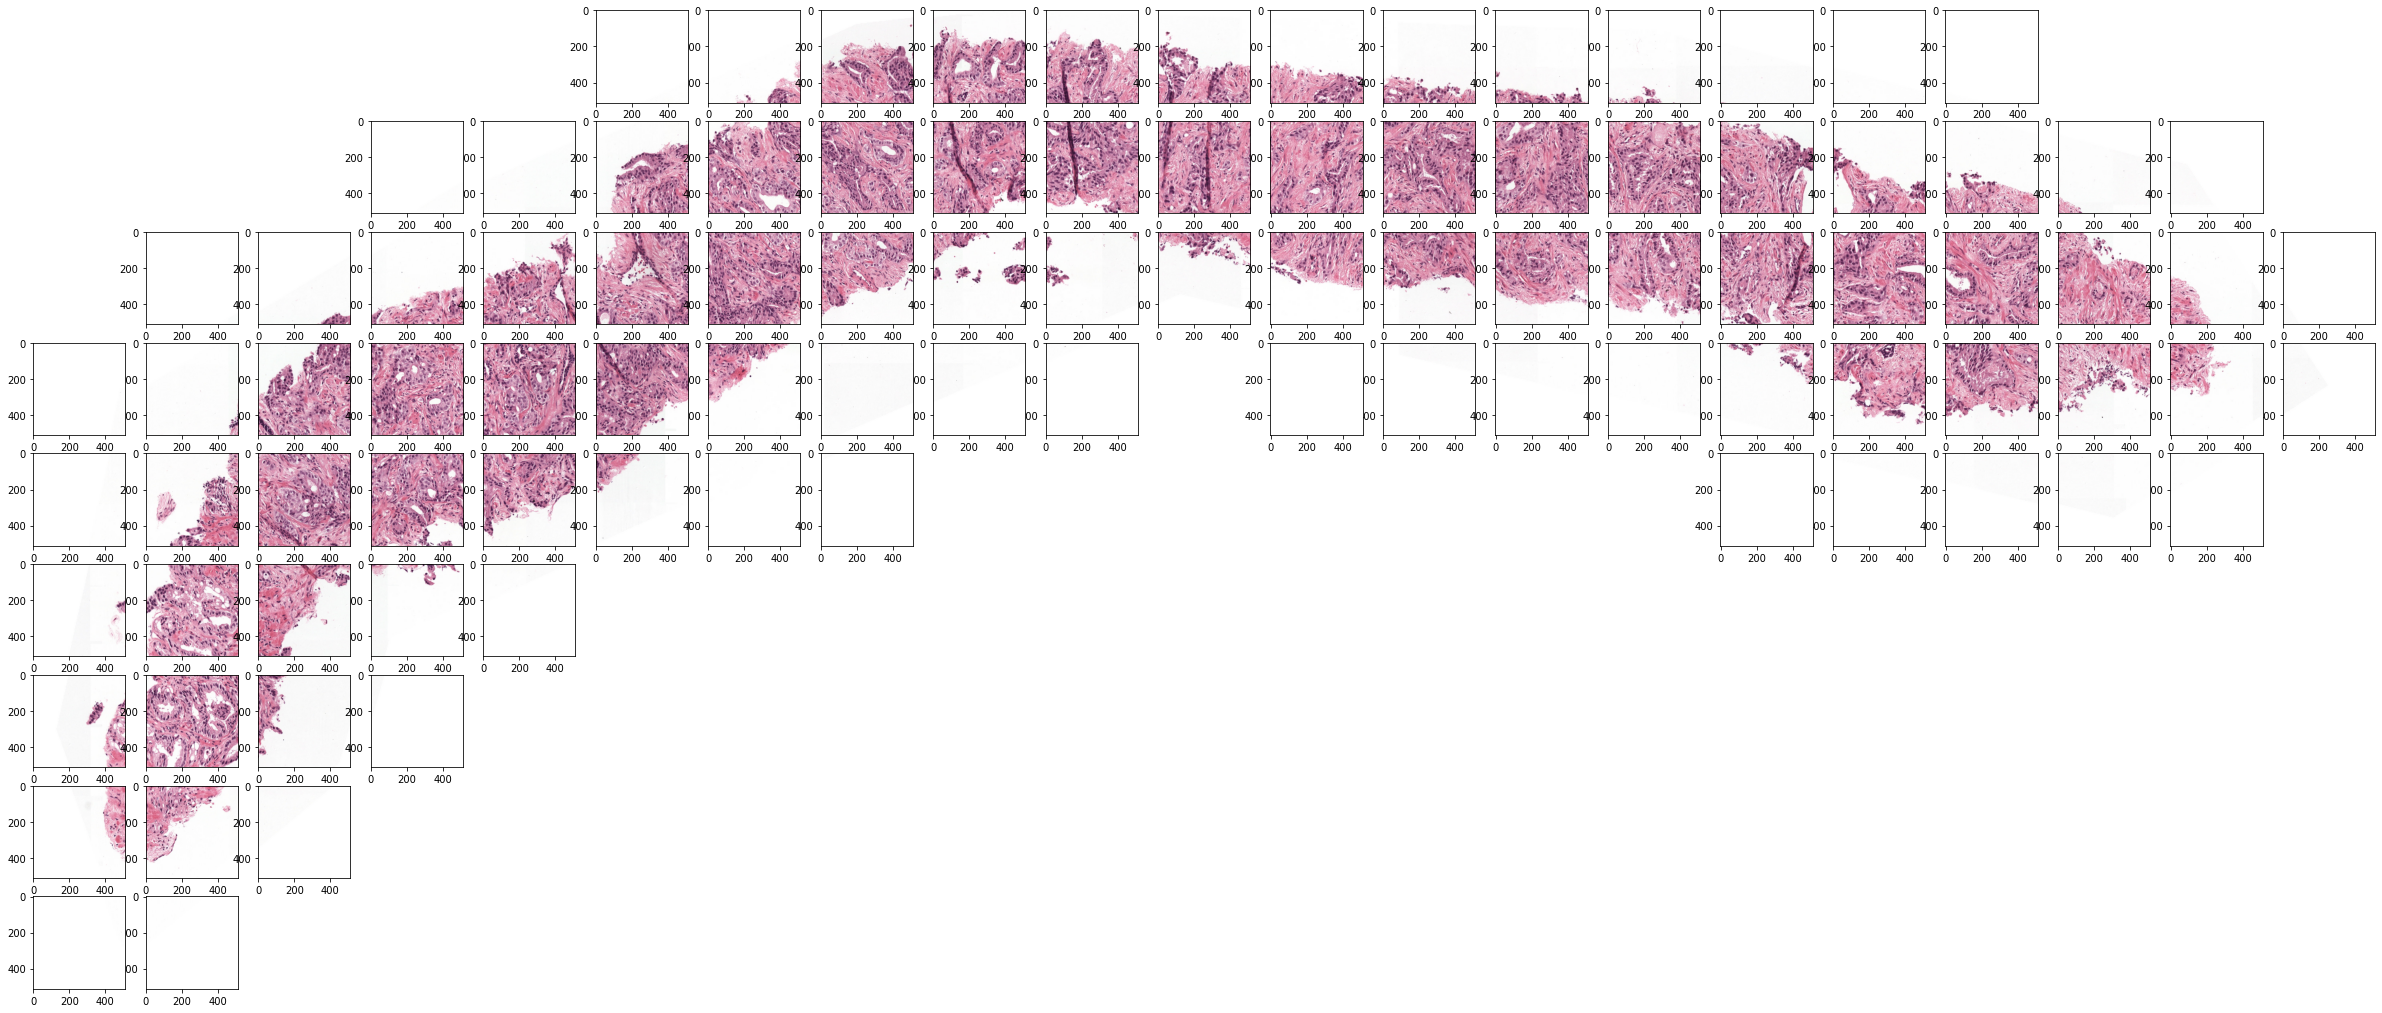

In [8]:
#Pick a specific image
TILE_DIR = '/media/tjhart/M.2 Vol 2/image_train/'
IMG_DIR = '/home/cancer_research/data/panda-kaggle/radboud_images/'

# Open original tiff image
current_image = '1233'
whole_image = mpimg.imread(IMG_DIR + current_image + '.tiff')

# Get all tiles for image
names = [name for name in os.listdir(TILE_DIR) if name.startswith(current_image)]

#Reconstruct the image from tiles 
n_tiles_height = int(np.ceil(whole_image.shape[0]/512))
n_tiles_width = int(np.ceil(whole_image.shape[1]/512))
plt.figure(figsize = (n_tiles_width*2,n_tiles_height*2))
for name in names:
    plt.subplot(n_tiles_height,n_tiles_width,n_tiles_width*int(name.split('_')[-2]) + int(name.split('_')[-1].split('.')[0])+1)
    img = mpimg.imread(TILE_DIR + name)
    plt.imshow(img)
plt.show()

## Move test images to test file

In [3]:
import shutil

VAL_IMAGES = '/media/tjhart/M.2 Vol 2/image_validation/'
VAL_MASKS = '/media/tjhart/M.2 Vol 2/mask_validation/'
TEST_IMAGES = '/media/tjhart/M.2 Vol 2/image_test/'
TEST_MASKS = '/media/tjhart/M.2 Vol 2/mask_test/'

# Move test files to test folders
with open('../data/test.txt', 'r') as f:
    lines = f.read().splitlines()
    images = [name for name in os.listdir(VAL_IMAGES)]
    images = [name for name in images if name.startswith(tuple(lines))]

    masks = [name for name in os.listdir(VAL_MASKS)]
    masks = [name for name in masks if name.startswith(tuple(lines))]

    # Move images
    for file in tqdm(images):
        shutil.move(VAL_IMAGES + file, TEST_IMAGES + file)

    # Move masks
    for file in tqdm(masks):
        shutil.move(VAL_MASKS + file, TEST_MASKS + file)


0it [00:00, ?it/s]
0it [00:00, ?it/s]
